In [152]:
import numpy as np
import torch
import mod
from tqdm import tqdm
from matplotlib import pyplot as plt

def getMSDRatePair(symbols1, symbols2, SNR1_lin, SNR2_lin, alpha):

    M1 = symbols1.size
    M2 = symbols2.size

    M = M1*M2

    device = torch.device('cuda:0')

    xx, ww = GH(n=16)
    xx = xx.reshape((xx.size, 1, 1))
    xx = torch.tensor(xx, dtype=torch.complex64, device=device)
    ww = torch.tensor(ww, dtype=torch.float32, device=device)

    # 基本层
    s1 = torch.tensor(symbols1*np.sqrt(SNR1_lin*(1-alpha)),
                      dtype=torch.complex64, device=device)
    s2 = torch.tensor(symbols2*np.sqrt(SNR1_lin*alpha),
                      dtype=torch.complex64, device=device)

    symbols = s1+s2.T
    symbols = symbols.reshape((M, 1))

    metric_num = torch.exp(-abs(xx-symbols+symbols.T)**2)
    metric_den = torch.exp(-abs(xx-s2+s2.T)**2)

    tmp_num = torch.log2(torch.sum(metric_num, axis=1))
    tmp_den = torch.log2(torch.sum(metric_den, axis=1))

    tmp1 = torch.sum(ww*torch.sum(tmp_num, axis=1))/(M*np.pi)
    tmp2 = torch.sum(ww*torch.sum(tmp_den, axis=1))/(M2*np.pi)

    Rbc = np.log2(M1)-tmp1+tmp2

    # 增强层
    s2 = torch.tensor(symbols2*np.sqrt(SNR2_lin*alpha),
                      dtype=torch.complex64, device=device)

    metric2 = torch.exp(-abs(xx-s2+s2.T)**2+abs(xx)**2)

    tmp = torch.log2(torch.sum(metric2, axis=1))

    Ruc = np.log2(M2)-torch.sum(ww*torch.sum(tmp, axis=1))/(M2*np.pi)

    return Rbc, Ruc

def GH(n=16):

    p = np.zeros((n+1, n+1))
    p[0, n] = 1
    p[1, n-1:] = np.array([1, 0])*2
    for k in range(2, n+1):
        p[k, n-k:] = 2*np.append(p[k-1, n-k+1:], 0) - \
            2*(k-1)*np.insert(p[k-2, n-k+2:], 0, [0, 0])

    x = np.roots(p[n, :])
    w = np.zeros(n)
    for k in range(n):
        w[k] = 2**(n-1)*np.math.factorial(n)*np.sqrt(np.pi) / \
            (n**2*np.polyval(p[n-1, :], x[k])**2)

    x = np.reshape(x, (1, n))
    w = np.reshape(w, (1, n))

    xx = x+1j*x.T
    ww = w*w.T

    xx = xx.flatten(order='F')
    ww = ww.flatten(order='F')

    xx = xx.reshape((1, len(xx)))
    ww = ww.reshape((1, len(ww)))

    return xx, ww

In [153]:
M1 = 4
M2 = 4
K1 = int(np.log2(M1))
K2 = int(np.log2(M2))

M = M1*M2
K = int(np.log2(M))

SNR1_dB = 7
SNR2_dB = 10

SNR1 = 10**(.1*SNR1_dB)
SNR2 = 10**(.1*SNR2_dB)

In [154]:
symbols1, labels1 = mod.grayQAM(M1)
symbols2, labels2 = mod.grayQAM(M2)
# mod.showConsteDiagram(symbols2, labels2)

In [155]:
alpha_vec = np.arange(0, 1.1, 0.1)
R1 = np.zeros(alpha_vec.size)
R2 = np.zeros(alpha_vec.size)

for i in tqdm(range(alpha_vec.size)):  
    alpha = alpha_vec[i]
    r1, r2 = getMSDRatePair(symbols1, symbols2, SNR1, SNR2, alpha)
    R1[i] = r1
    R2[i] = r2

100%|██████████| 11/11 [00:00<00:00, 43.14it/s]


(-0.09968324899673463,
 2.093350851535797,
 -0.09510611295700074,
 1.9972283720970154)

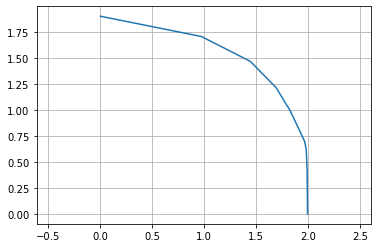

In [157]:
plt.plot(R2, R1)
plt.grid()
plt.axis('equal')